In [1]:
import pymongo
import json
import pandas as pd
import time
import re
import numpy as np
from gmplot import gmplot
import pickle as pickle

In [2]:
client=pymongo.MongoClient()

In [3]:
client.list_database_names()

['admin', 'config', 'local', 'pollution', 'twitterdb']

In [4]:
sample=client.pollution.tweetcollection
population=client.twitterdb.twitter_search
# newpopulation=client.twitterdb.twitterdb

In [6]:
# db.tweetcollection.find({"place":{"$ne": None}}).count() # with place tweets
# db.tweetcollection.find({"geo":{"$ne": None}}).count() # with exact location

In [5]:
category_0=["r'(pollution)","#airpollution","la pollution de l'air","la #pollution","air pollution","l'air #pollution"]

In [6]:
category_0

["r'(pollution)",
 '#airpollution',
 "la pollution de l'air",
 'la #pollution',
 'air pollution',
 "l'air #pollution"]

In [7]:
regx = re.compile(r'('+'|'.join(category_0)+')', re.IGNORECASE)
regx

re.compile(r"(r'(pollution)|#airpollution|la pollution de l'air|la #pollution|air pollution|l'air #pollution)",
re.IGNORECASE|re.UNICODE)

In [8]:
db=population
pattern =regx
start=time.time()
withplace=list(db.find({"place":{"$ne": None}}))
print(len(withplace))
print(time.time()-start)

204410
239.9993257522583


In [36]:
# withlocation[0]

In [9]:
path="../../output/placejson.p"
with open(path, 'bw') as f:
    pickle.dump(withplace, f)

# information extraction

In [32]:
path="../../output/placejson.p"
with open(path,'br') as f:
    withplace=pickle.load(f,encoding='utf-8')

In [11]:
coordinates = None
coordinates = [None,None] if not coordinates else cooridnates
coordinates

[None, None]

In [12]:
def get_coordinate(this_tweet):
    '''input  dict  tweet
       output list [LONGITUDE LATITUDE]'''
    # There are geo-tagged 3 place store geoinformation 
    # User self-report place 
    # geo  1 Latitude 2 Longitude 
    # coordinates 1 LONGITUDE,2 Latitude 
    # coordinate box same as coordinates
    coordinates = None
    try:
        coordinates=this_tweet['coordinates']['coordinates']
#         print('coordinates {}'.format(this_tweet['coordinates']['coordinates']))
    except Exception as e:
        pass
    
    try:
        # take average over coordinates box
        coordinates=list(np.array(this_tweet['place']['bounding_box']['coordinates'][0]).mean(axis=0))
    except Exception as e:
        pass
    
    coordinates = [None,None] if not coordinates else coordinates
    return coordinates

def get_retweetid(tweet):
    try:
        return(tweet["retweeted_status"]["id"])
    except: 
        return None
    
def get_retweet_username(tweet):
    try:
        return(tweet["retweeted_status"]["user"]["name"])
    except: 
        return None
def get_retweet_followers_count(tweet):
    try:
        return(tweet["retweeted_status"]["user"]["followers_count"])
    except: 
        return None
def get_retweet_fa(tweet):
    try:
        return(tweet["retweeted_status"]["favorite_count"])
    except: 
        return None
def get_retweet_retw(tweet):
    try:
        return(tweet["retweeted_status"]["retweet_count"])
    except: 
        return None
def get_retweet_rep(tweet):
    try:
        return(tweet["retweeted_status"]["reply_count"])
    except: 
        return None
def get_full_text(tweet):
    try:
        return(tweet["extended_tweet"]["full_text"])
    except:
        return(tweet["text"])

def jsontopandas(tweets_data):
    tweets=pd.DataFrame()
    tweets['id'] = list(map(lambda tweet: tweet['_id'], tweets_data))
    tweets['longitude']=list(map(lambda tweet:get_coordinate(tweet)[0], tweets_data))
    tweets['latitude']=list(map(lambda tweet: get_coordinate(tweet)[1], tweets_data))
    tweets['place_country']=list(map(lambda tweet: tweet['place']['country'] if tweet['place']!= None else None, tweets_data))
    tweets['place_full_name']=list(map(lambda tweet: tweet['place']['full_name'] if tweet['place']!= None else None, tweets_data))
    tweets['text']=list(map(lambda tweet: get_full_text(tweet), tweets_data))
    tweets["user_id"]=list(map(lambda tweet:tweet["user"]["id"],tweets_data))
    tweets["user_name"]=list(map(lambda tweet:tweet["user"]["name"],tweets_data))
    tweets["user_followers"]=list(map(lambda tweet:tweet["user"]["followers_count"],tweets_data))
    tweets['user_loc']=list(map(lambda tweet: tweet['user']['location'], tweets_data))
    tweets['lang']=list(map(lambda tweet: tweet['lang'], tweets_data))
    tweets['created_at']=list(map(lambda tweet: time.strftime('%Y-%m-%d %H:%M:%S', time.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y')), tweets_data))
#     tweets['retweet_id']=list(map(lambda tweet: get_retweetid(tweet),tweets_data))
#     tweets['retweet_user']=list(map(lambda tweet: get_retweet_username(tweet),tweets_data))
    return tweets

In [13]:
tweet_table=jsontopandas(withplace)

In [14]:
tweet_table.head()

,id,longitude,latitude,place_country,place_full_name,text,user_id,user_name,user_followers,user_loc,lang,created_at
0,1003422947648958464,-1.449612,53.383164,United Kingdom,"Sheffield, England",I sure love when a huge moth climbs into my wa...,37952387,Gradon 🏳️‍🌈🐝,79,United Kingdom,en,2018-06-03 23:47:28
1,1003424491979116544,-96.699604,33.194651,United States,"McKinney, TX",So I’m at work and we are playing outside when...,2357488093,Bethany Baker,445,"McKinney, TX",en,2018-06-03 23:53:36
2,1003424636686733315,-77.604684,41.117936,United States,"Pennsylvania, USA","What’s that, dust in my eye? If you can watch...",1952866536,John Barr ESPN,3994,Delco/The Road,en,2018-06-03 23:54:10
3,1003424733810057218,-84.206541,33.789502,United States,"Pine Lake, GA",So I got mosquito bites on my balls and yeah.....,215493638,Runt,1566,"Atlanta, GA",en,2018-06-03 23:54:33
4,1003424860956184581,0.314300,61.304725,United States,"Alaska, USA","2.4 magnitude #earthquake. 30 km from Y, #AK, ...",362523555,Earthquake Alerts,158724,None,en,2018-06-03 23:55:04


In [44]:
# tweet_table.lang.value_counts()

In [57]:
# thistweet[thistweet.id==994759019909726208]

In [58]:
# thistweet.text[51]

In [15]:
tweet_table.to_csv("../../output/withplace_pop.csv",encoding='utf-8',index=False)

# france

In [17]:
import matplotlib.pyplot as plt

In [2]:
tweet_table=pd.read_csv("../../output/withplace_pop.csv")

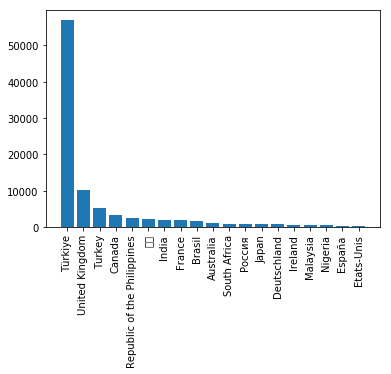

In [18]:
label=tweet_table.place_country.value_counts().index[1:20]
value=tweet_table.place_country.value_counts()[1:20]
index=np.arange(len(label))
plt.bar(index,value)
plt.xticks(index,label,rotation=90)
plt.show()

In [19]:
france=tweet_table[tweet_table.place_country=="France"]

In [20]:
france=france.reset_index().iloc[:,1:]

In [21]:
france.head()

,id,longitude,latitude,place_country,place_full_name,text,user_id,user_name,user_followers,user_loc,lang,created_at
0,1003504559875153921,9.046206,41.520942,France,"Pianottoli-Caldarello, France",Tout ça semble tellement simple... mais ça ne ...,1630482236,patrice salini,915,pianottoli caldarello,fr,2018-06-04 05:11:45
1,1003545074322591744,1.582971,48.965238,France,"Boissy-Mauvoisin, France",La définition littérale d’un bug https://t.co/...,34577688,Pierre Dandumont,3651,Dans ma campagne.,fr,2018-06-04 07:52:45
2,1003547782718939136,2.347003,48.858834,France,"Paris, France","@pipedrive Hello, we are a paid customer (@mad...",1264922016,Youssef Rahoui,664,Paris,en,2018-06-04 08:03:31
3,1003548448514347009,2.347003,48.858834,France,"Paris, France",Je plussoie ++ #vegetalisonsparis https://t.co...,1095432156,Agathe Lélu,962,Paris,fr,2018-06-04 08:06:09
4,1003555075699200000,2.347003,48.858834,France,"Paris, France",@jlmoudenc un exemple à prendre pour #Toulouse...,811609616408870912,Kiricus,44,"Toulouse, France",fr,2018-06-04 08:32:29


In [27]:
france.text[10]

"#SEDD  @Mc_Lanne conclut la conférence en rappelant que @generalifrance a été l'un des 1er #assureurs à se positionner sur les sujets du #climat et de la #pollution  #santé 👏👏👌 https://t.co/DnBg6PTT90"

In [28]:
# france=france.iloc[:,1:]
france.to_csv("../../output/france_pop.csv",encoding='utf-8',index=False)